# General Plotting Function

## Load Libraries

In [49]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as patch
import time
from functools import wraps
import pyxpcm
from pyxpcm.models import pcm
import run_throughs.sithom_plot_style as sps
import run_through_gmm as rtg
print('xarray', xr.__version__)
print('matplotlib', matplotlib.__version__)

xarray 0.15.1
matplotlib 3.2.2


In [18]:
def _return_name(K, pca):

    return "nc/i-metric-joint-k-" + str(K) + "-d-" + str(pca)


def _return_plot_folder(K, pca):
    folder = "../FBSO-Report/images/i-metric-joint-k-" + str(K) + "-d-" + str(pca) + "/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder


def _return_folder(K, pca):

    folder = _return_name(K, pca) + "/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder


def _return_pair_name(K, pca):
    return "nc/pair-i-metric-k-" + str(K) + "-d-" + str(pca)


def _return_pair_folder(K, pca):
    folder = "nc/pair-i-metric-k-" + str(K) + "-d-" + str(pca) + "/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder

## Helper Plot Functions

In [34]:
def southern_ocean_axes_setup(ax, fig):
    carree = ccrs.PlateCarree()
    ax.set_extent([-180, 180, -90, -30], carree)
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

    def plot_boundary():
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.45
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    plot_boundary()

In [29]:
def label_subplots(axs, start_from=0, fontsize=13):
    if isinstance(axs, list):
        axs = np.asarray(axs)

    orig_label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M"]
    assert len(axs.ravel()) + start_from <= len(orig_label_list)
    subset_labels = []
    for i in range(len(axs.ravel())):
        subset_labels.append(orig_label_list[i + start_from])
    for i, label in enumerate(subset_labels):
        axs.ravel()[i].text(
            0.02,
            0.95,
            "(" + label.lower() + ")",
            color="black",
            transform=axs.ravel()[i].transAxes,
            fontsize=fontsize,
            fontweight="bold",
            va="top",
        )

## Separate plots

In [170]:
def sep_plots(da_list, var_list):

    map_proj = ccrs.SouthPolarStereo()
    carree = ccrs.PlateCarree()

    fig = plt.figure()

    num_da = len(da_list)

    fig, axes = plt.subplots(1, num_da, subplot_kw={"projection": map_proj})

    for i in range(num_da):
        southern_ocean_axes_setup(axes[i], fig)
        #sps.ds_for_graphing(da_list[i].to_dataset()).to_array().plot(
        da_list[i].plot(
            transform=carree,  # the data's projection
            ax=axes[i],
            subplot_kws={"projection": map_proj},  # the plot's projection
            cbar_kwargs={
                "shrink": 0.8,
                "label": var_list[i],
                "orientation": "horizontal",  # xr_da.name
                "pad": 0.01
            },
        )
        axes[i].coastlines()
        axes[i].set_title("")
        
    label_subplots(axes)

## Plot many on one axes

In [47]:
def plot_on_one(da):
    carree = ccrs.PlateCarree()
    map_proj = ccrs.SouthPolarStereo()
    pairs = da.coords["pair"].values.shape[0]

    gs = GridSpec(
        nrows=2,
        ncols=pairs,
        width_ratios=[1 / pairs for x in range(pairs)],
        height_ratios=[1, 0.05],
        wspace=0.15,
    )

    fig = plt.gcf()

    ax1 = fig.add_subplot(gs[0, :], projection=map_proj)
    cbar_axes = [fig.add_subplot(gs[1, i]) for i in range(pairs)]

    southern_ocean_axes_setup(ax1, fig)
    cmap_list = sps.return_list_of_colormaps(pairs, fade_to_white=False)
    
    for i in range(pairs):
        im = da.isel(pair=i).plot(
            cmap=cmap_list[i],
            vmin=0,
            vmax=1,
            ax=ax1,
            add_colorbar=False,
            transform=carree,
            subplot_kws={"projection": map_proj},
        )
        cbar = plt.colorbar(
            im, cax=cbar_axes[i], orientation="horizontal", ticks=[0, 1]
        )
        cbar.set_label(da.coords["pair"].values[i])
    plt.suptitle("")
    plt.title("")
    ax1.set_title("")
    ax1.coastlines()

## Translate_i_metric

In [144]:
# @jit(nopython=True)
def go_through_with_numba(cart_prod, i_metric, sorted_version, threshold):
    if True:
        pair_i_metric_list = []

        pair_list = []
        
        for pair in cart_prod:
            print("pair", pair)
            """pair [0 1] pair [0 2] pair [0 3] 
               pair [1 2] pair [1 3] pair [2 3]"""
            temp_list = for_loops_with_numba(pair, i_metric, sorted_version, threshold)
            if temp_list[2] == True:
                pair_list.append(temp_list[0])
                pair_i_metric_list.append(temp_list[1])
            # time, YC, XC
            # shape (60, 2, 588, 2160)
    print("pair_list", pair_list)
        
    return pair_i_metric_list, pair_list

#@jit(nopython=True)
def for_loops_with_numba(pair, i_metric, sorted_version, threshold):
    shape = np.shape(sorted_version)
    print("shape", shape)
    # shape (60, 2, 588, 2160)
    at_least_one_point = False
    # float32 changed from np.zeros
    pair_i_metric = np.zeros([shape[0], shape[2], shape[3]]#, dtype='float64'
                            )
    pair_i_metric[:, :, :] = np.nan
    for i in range(shape[0]):  # 60
        for j in range(shape[2]):  # 588
            for k in range(shape[3]):  # 2160
                if np.array_equal(pair, sorted_version[i, :, j, k]):
                    # sorted_version (60, 2, 588, 2160)
                    if i_metric[i, j, k] >= threshold:
                        # i_metric (60, 588, 2160)
                        pair_i_metric[i, j, k] = i_metric[i, j, k]
                        at_least_one_point = True
    return [pair, pair_i_metric, at_least_one_point]


def pair_i_metric(ds, threshold=0.05):
    
    print("ds.A_B.values.shape", ds.A_B.values.shape)

    sorted_version = np.sort(ds.A_B.values, axis=1)
    print("sorted_version.shape", sorted_version.shape)
    # sorted_version (60, 2, 588, 2160)

    i_metric = ds.IMETRIC.isel(Imetric=0).values

    print("i_metric", i_metric.shape)
    # i_metric (60, 588, 2160)

    list_no = [i for i in range(int(np.nanmax(sorted_version)) + 1)]

    print("list_no", list_no)

    # list_no [0, 1, 2, 3]

    cart_prod = [
        np.array([a, b]) for a in list_no for b in list_no if a <= b and a != b
    ]     
    # [array([0, 1]), array([0, 2]), array([0, 3]), array([1, 2]), array([1, 3]), array([2, 3])]

    print("cart_prod", cart_prod)

    pair_i_metric_list, pair_list = go_through_with_numba(
        cart_prod, i_metric, sorted_version, threshold
    )
    
    print("pair_i_metric_list", pair_i_metric_list)
    print("pair_i_metric_list len", len(pair_i_metric_list))
    print("pair_list", pair_list)
    print("pair_list len", len(pair_list))
    
    shape = np.shape(sorted_version)
    # shape (60, 2, 588, 2160)

    pair_i_metric_array = np.zeros(
        [len(pair_i_metric_list), shape[0], shape[2], shape[3]]
    )

    for i in range(len(pair_i_metric_list)):

        pair_i_metric_array[i, :, :, :] = pair_i_metric_list[i][:, :, :]

    pair_str_list = []

    for i in range(len(pair_list)):
        pair_str_list.append(
            str(pair_list[i][0] + 1) + " to " + str(pair_list[i][1] + 1)
        )

    da = xr.DataArray(
        pair_i_metric_array,
        dims=["pair", "time", "YC", "XC"],
        coords={
            "XC": ds.coords["XC"].values,
            "YC": ds.coords["YC"].values,
            "time": ds.coords["time"].values,
            "pair": pair_str_list,
        },
    )

    return da


In [154]:
for K in [2]:
    ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-" + str(K) + "-d-3.nc")
    new_da = pair_i_metric(ds, threshold=0.01)
    new_da.to_netcdf("pair_i_metric_k_"+ str(K) +".nc")

ds.A_B.values.shape (60, 2, 588, 2160)
sorted_version.shape (60, 2, 588, 2160)
i_metric (60, 588, 2160)
list_no [0, 1]
cart_prod [array([0, 1])]
pair [0 1]
shape (60, 2, 588, 2160)
pair_list [array([0, 1])]
pair_i_metric_list [array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [146]:
ls

Gen-Plot-Func.ipynb   meta.yaml             readthedocs.yml
HOW_TO_RELEASE        nc/                   requirements.txt
LICENSE.txt           old/                  run_through_gmm.py
README.md             old-ipynb/            run_throughs/
__pycache__/          pair_i_metric_k_4.nc  setup.py
docs/                 pc-check.ipynb        translate_nc.py
i_metric.py           plot_i_metric.py      web/
interp.nc             pyxpcm/


## Load datasets

In [4]:
ds = xr.open_dataset("/Volumes/BSOSE-DISC/pyxpcm/nc/i-metric-joint-k-5-d-3.nc")

In [7]:
ds.coords

Coordinates:
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31

In [11]:
ds.A_B.__str__()

"<xarray.DataArray 'A_B' (time: 60, rank: 2, YC: 588, XC: 2160)>\n[152409600 values with dtype=float64]\nCoordinates:\n  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9\n  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72\n  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31\nDimensions without coordinates: rank\nAttributes:\n    long_name:  Top Two Clusters\n    units:      \n    valid_min:  0\n    valid_max:  5"

In [12]:
ds.Imetric.__str__()

"<xarray.DataArray 'Imetric' (Imetric: 1)>\narray([0])\nDimensions without coordinates: Imetric"

In [17]:
ds.IMETRIC.__str__()

"<xarray.DataArray 'IMETRIC' (time: 60, Imetric: 1, YC: 588, XC: 2160)>\n[76204800 values with dtype=float64]\nCoordinates:\n  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9\n  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72\n  * time     (time) datetime64[ns] 2008-01-31T10:24:00 ... 2012-12-31\nDimensions without coordinates: Imetric\nAttributes:\n    long_name:  I metric\n    units:      \n    valid_min:  0\n    valid_max:  1"

## Load Data

In [156]:
def run_through_plot(K=5, pca=3, save_nc=False):

    # link_to_netcdf = rtg._return_name(K, pca) + '.nc'
    # ds = xr.open_dataset(link_to_netcdf)
    # print(ds.__str__())

    batch_size = 2

    for i in range(40, 42, batch_size):
        print("running", i)
        if save_nc:
            da = tnc.pair_i_metric(
                ds.isel(time=slice(i, i + batch_size)), threshold=0.05
            )
        if save_nc:
            da.rename("pair_i_metric").to_dataset().to_netcdf(
                rtg._return_pair_folder(K, pca) + str(i) + ".nc"
            )
        else:
            da = xr.open_dataset(
                rtg._return_pair_folder(K, pca) + str(i) + ".nc"
            ).to_array()
        
        return da
        #for j in range(batch_size):
 
"""
for K in [  # 5,
    # 4,
    # 2,
    5
]:
    run_through_plot(K=K)
"""

da  = run_through_plot(K=5)
    

running 40


## Run Test A

[<matplotlib.colors.LinearSegmentedColormap object at 0x7f98cae65a00>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8af0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8ee0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8c70>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8e50>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8eb0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8cd0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7f958eab8f10>]


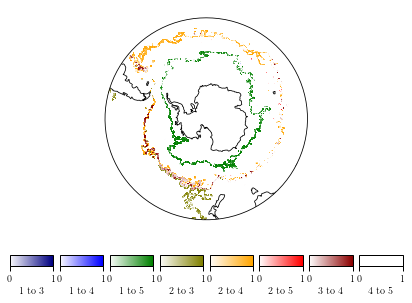

In [159]:
plot_on_one(da.isel(time=0))
plt.savefig('../FBSO-Report/images/fig4-new.png', dpi=900, bbox_inches='tight')

## Run Test B

In [161]:
# ds = xr.open_dataset("/Volumes/BSOSE-DISC/pyxpcm/nc/i-metric-joint-k-5-d-3.nc")
ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")

<Figure size 432x288 with 0 Axes>

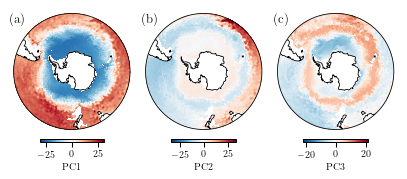

In [162]:
da_temp = ds.PCA_VALUES.isel(time=40)
sep_plots([da_temp.isel(pca=0), 
           da_temp.isel(pca=1), 
           da_temp.isel(pca=2)],
          ['PC1', 'PC2', 'PC3'])
plt.savefig('../FBSO-Report/images/fig1-new.png', dpi=900, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

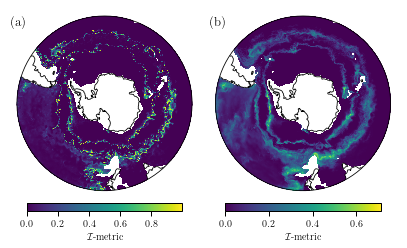

In [173]:
sep_plots([ds.IMETRIC.isel(Imetric=0, time=40), 
           ds.IMETRIC.isel(Imetric=0).mean(dim="time", skipna=True)],
          ['$\mathcal{I}$-metric ',
           '$\mathcal{I}$-metric'])
plt.savefig('../FBSO-Report/images/fig3-new.png', dpi=900, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

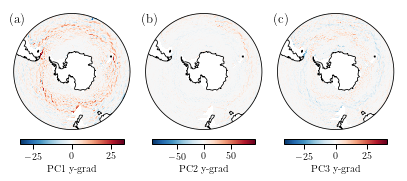

In [172]:
da_temp = ds.PCA_VALUES.isel(time=40).differentiate("YC") 
sep_plots([da_temp.isel(pca=0), 
           da_temp.isel(pca=1), 
           da_temp.isel(pca=2)],
          ['PC1 y-grad', 
           'PC2 y-grad', 
           'PC3 y-grad'])
plt.savefig('../FBSO-Report/images/fig6-new.png', dpi=900, bbox_inches='tight')

/Users/simon/anaconda3/envs/fronts4/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<Figure size 432x288 with 0 Axes>

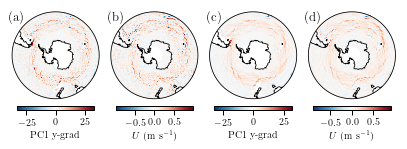

In [171]:
main_dir = "/Users/simon/fbso/fbso/bsose_monthly/"
uvel = main_dir + "bsose_i106_2008to2012_monthly_Uvel.nc"
uvel_ds = xr.open_dataset(uvel).isel(Z=15)
ds = xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")

sep_plots([ds.PCA_VALUES.isel(time=40, pca=0).differentiate("YC"),
           uvel_ds.UVEL.isel(time=40),
           ds.PCA_VALUES.isel(pca=0).differentiate("YC").mean(dim="time", skipna=True),
           uvel_ds.UVEL.mean(dim="time", skipna=True)],          
          ['PC1 y-grad', 
           r'$U$ (m s$^{-1}$)', 
           'PC1 y-grad',
           r'$U$ (m s$^{-1}$)'])

plt.savefig('../FBSO-Report/images/compare-sobel-with-U.png', dpi=900, bbox_inches='tight')

## Take Correlation between Grad and Velocity

In [ ]:
import numpy.ma as ma

uvel_ds = xr.open_dataset(uvel).isel(Z=15)
pca_ds = (
    xr.open_dataset("~/pyxpcm/nc/i-metric-joint-k-4-d-3.nc")
    .isel(pca=0)
    .differentiate("YC")
)

cor_list = []

for time_i in range(0, 60):
    cor = ma.corrcoef(ma.masked_invalid(uvel_ds.isel(time=time_i).UVEL.values.ravel()), 
                      ma.masked_invalid(pca_ds.isel(time=time_i).PCA_VALUES.values.ravel()))
    cor_list.append(cor[1, 0])
    
plt.plot(range(0, 60), cor_list)

In [175]:
cor_list

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

## Plot Several pair-I-metrics together

In [ ]:
def plot_on_one_mult(da_list):
    
    carree = ccrs.PlateCarree()
    map_proj = ccrs.SouthPolarStereo()
    
    pairs_list = []
    width_ratio_lol = []

    
    for i in range(len(da_list):)
        pairs = da_list[i].coords["pair"].values.shape[0]
        pairs_list.append(pairs)
        width_ratios_lol.append([0.5 / pairs for x in range(pairs)])
        
        
    gs = GridSpec(
        nrows=2,
        ncols=pairs,
        width_ratios=[1 / pairs for x in range(pairs)],
        height_ratios=[1, 0.05],
        wspace=0.15,
    )

    fig = plt.gcf()

    ax1 = fig.add_subplot(gs[0, :], projection=map_proj)
    cbar_axes = [fig.add_subplot(gs[1, i]) for i in range(pairs)]

    southern_ocean_axes_setup(ax1, fig)
    cmap_list = sps.return_list_of_colormaps(pairs, fade_to_white=False)
    
    for i in range(pairs):
        im = da.isel(pair=i).plot(
            cmap=cmap_list[i],
            vmin=0,
            vmax=1,
            ax=ax1,
            add_colorbar=False,
            transform=carree,
            subplot_kws={"projection": map_proj},
        )
        cbar = plt.colorbar(
            im, cax=cbar_axes[i], orientation="horizontal", ticks=[0, 1]
        )
        cbar.set_label(da.coords["pair"].values[i])
    plt.suptitle("")
    plt.title("")
    ax1.set_title("")
    ax1.coastlines()